In [12]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geojson

import seaborn as sns
import matplotlib.pyplot as plt
import folium

%matplotlib inline

pd.set_option('display.max_rows', 1000)

## VISUALIZE ARTURO MODEL (Already cleaned)

El modelo de arturo.300000kms.net está dividido en dos JSON:
>- datos de entrenamiento en json con columnas value y dm_id
>- modelo de datos urbanísticos en geojson

In [2]:
arturo_path = '../data/raw/arturo' # arturo_modelo.json & model.geojson

with open(f"{arturo_path}/arturo_modelo.json") as f:
    arturo_json = geojson.load(f)
    # list of dict with keys: value and dm_id
    
urban_df = gpd.read_file(f"{arturo_path}/model.geojson")

EDA de datos de entrenamiento

In [3]:
arturo_json_pd = pd.DataFrame(arturo_json)

display(arturo_json_pd.head(10).T)
display(arturo_json_pd.info())

print(f"Unique values in value col: \t {arturo_json_pd['value'].nunique()*100/arturo_json_pd['value'].size}")
print(f"Unique values in dm_id col: \t {arturo_json_pd['dm_id'].nunique()*100/arturo_json_pd['dm_id'].size}")

# en ambas columnas sólo hay valores únicos
# dm_id es la col que conecta con el geojson
# value es el valor de calidad votado por los ciudadanos

,0,1,2,3,4,5,6,7,8,9
value,21.0104,20.2034,15.743,17.2082,15.0262,21.5883,16.4932,23.359,27.0116,25.6708
dm_id,1001,10015,10069,10070,10072,10075,10087,10093,10102,10105


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5465 entries, 0 to 5464
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   5465 non-null   float64
 1   dm_id   5465 non-null   object 
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


None

Unique values in value col: 	 100.0
Unique values in dm_id col: 	 100.0


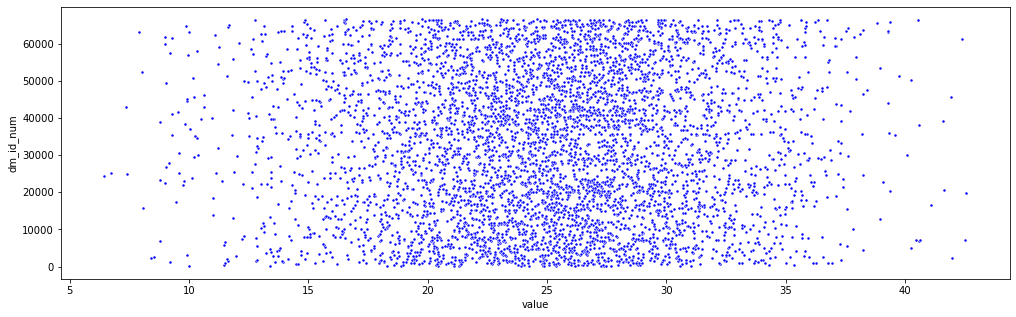

Range in value col: 	 [6.447847761767921,  42.57460885029834]
Range in dm_id col: 	 [25,  66506]


In [4]:
arturo_json_pd['dm_id_num'] = pd.to_numeric(arturo_json_pd['dm_id'], downcast = 'integer')

fig, ax = plt.subplots(figsize = (17,5))
sns.scatterplot(data = arturo_json_pd[0:100000], x = 'value', y = 'dm_id_num', 
                marker = ".", color ="b", ax = ax)
plt.show()

print(f"Range in value col: \t [{arturo_json_pd['value'].min()},  {arturo_json_pd['value'].max()}]")
print(f"Range in dm_id col: \t [{arturo_json_pd['dm_id_num'].min()},  {arturo_json_pd['dm_id_num'].max()}]")
# valores dm_id y value no están georeferenciados 

Los datos de geojson son un conjunto de indicadores empleados para entrenar el modelo de Arturo, geolocalizados a través del viario de Madrid (se desconoce el año del callejero 2019 ó 2019) y la col dm_id

In [5]:
## añadir columna de valoraciones de la calidad del esp publico en df
arturo_sorted = arturo_json_pd.set_index('dm_id').sort_values(by = 'dm_id')
urban_df = urban_df.join(arturo_sorted, on = 'dm_id')

In [6]:
urban_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66499 entries, 0 to 66498
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OGC_FID                        66499 non-null  object  
 1   geom_pu                        66499 non-null  object  
 2   dist_barri                     66483 non-null  object  
 3   dm_id                          66499 non-null  object  
 4   train                          66499 non-null  int64   
 5   land_use_mix                   66499 non-null  float64 
 6   closeness_small_parks          66499 non-null  float64 
 7   residence_ratio                66499 non-null  float64 
 8   block_area                     66499 non-null  float64 
 9   intersection_density           66499 non-null  float64 
 10  anisotropicity                 66499 non-null  float64 
 11  average_age                    66499 non-null  float64 
 12  age_diversity           

In [7]:
urban_df.describe().T

,count,mean,std,min,25%,50%,75%,max
train,66499.0,0.283313,0.626041,0.000000,0.000000,0.000000,0.000000,2.000000e+00
land_use_mix,66499.0,0.000158,0.000193,0.000000,0.000025,0.000080,0.000219,1.382000e-03
closeness_small_parks,66499.0,228.251022,235.693577,0.000000,1.778238,88.053379,500.000000,5.000000e+02
residence_ratio,66499.0,0.548509,0.301048,0.000000,0.366349,0.608774,0.783614,1.000000e+00
block_area,66499.0,22531.395302,128300.036284,0.000000,447.102083,1199.113636,4404.250000,2.292952e+06
intersection_density,66499.0,1.228758,3.014072,0.001365,0.204792,0.474158,1.223556,1.774461e+02
anisotropicity,66499.0,0.192449,0.538305,0.000000,0.032011,0.070023,0.181335,2.296704e+01
average_age,66499.0,106.741618,25.597476,0.000000,109.445970,117.614683,118.000000,1.180000e+02
age_diversity,66499.0,0.001274,0.001377,0.000000,0.000000,0.000000,0.002668,3.711000e-03
age_deviation_diversity,66499.0,0.000361,0.000447,0.000000,0.000000,0.000000,0.000676,2.563000e-03


In [8]:
# columnas que hablan sobre la morfología de la red viaria
col_via = ['closeness_primary_roads', 'closeness_secondary_roads', 'closeness_tertiary_roads',
          'tertiary_roads_length', 'street_length', 'street_one_way', 'street_orientation',
           'street_centrality_degree', 'street_centrality_eigenvector', 
           'street_centrality_betweenness', 'street_centrality_closeness', 
           'street_hierarchy_primary', 'street_hierarchy_secondary', 'street_hierarchy_tertiary']

# columnas que hablan sobre amenities
col_amenities = ['public_space_surface', 'parks_surface', 'parking_surface', 'warehouse_surface', 'commerce_surface',
                'cultural_surface', 'industrial_surface', 'industrial_rural_surface', 'sports_surface', 'hotel_surface',
                'garden_surface', 'office_surface']

col_densities = []

In [9]:
# vistazo a columnas que no sé qué son
display(urban_df[['OGC_FID', 'geom_pu', 'dist_barri', 'dm_id', 'average_quality', 'pk', 'geometry']].head())

# OGC_FID y pk son indexes
display(urban_df[['OGC_FID', 'dm_id', 'pk']].tail(19).T)

,OGC_FID,geom_pu,dist_barri,dm_id,average_quality,pk,geometry
0,1,SRID=25830;POINT(444133.736820226 4482808.8916...,1606,1,3.277406,1,"MULTILINESTRING ((-3.65969 40.49369, -3.65882 ..."
1,2,SRID=25830;POINT(444192.038205298 4482878.0294...,1606,2,3.113298,2,"MULTILINESTRING ((-3.65833 40.49494, -3.65848 ..."
2,3,SRID=25830;POINT(444134.537506681 4482885.3751...,1606,3,3.143822,3,"MULTILINESTRING ((-3.65969 40.49506, -3.65882 ..."
3,4,SRID=25830;POINT(445612.690578458 4479335.7195...,1603,4,5.740980,4,"MULTILINESTRING ((-3.64155 40.46301, -3.64146 ..."
4,5,SRID=25830;POINT(445606.319326282 4479354.4426...,1603,5,5.468163,5,"MULTILINESTRING ((-3.64161 40.46315, -3.64155 ..."


,66480,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498
OGC_FID,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498,66499
dm_id,66505,66506,66507,66508,66509,66510,66511,66512,66513,66514,66515,66516,66517,66518,66519,66520,66521,66522,66523
pk,66481,66482,66483,66484,66485,66486,66487,66488,66489,66490,66491,66492,66493,66494,66495,66496,66497,66498,66499


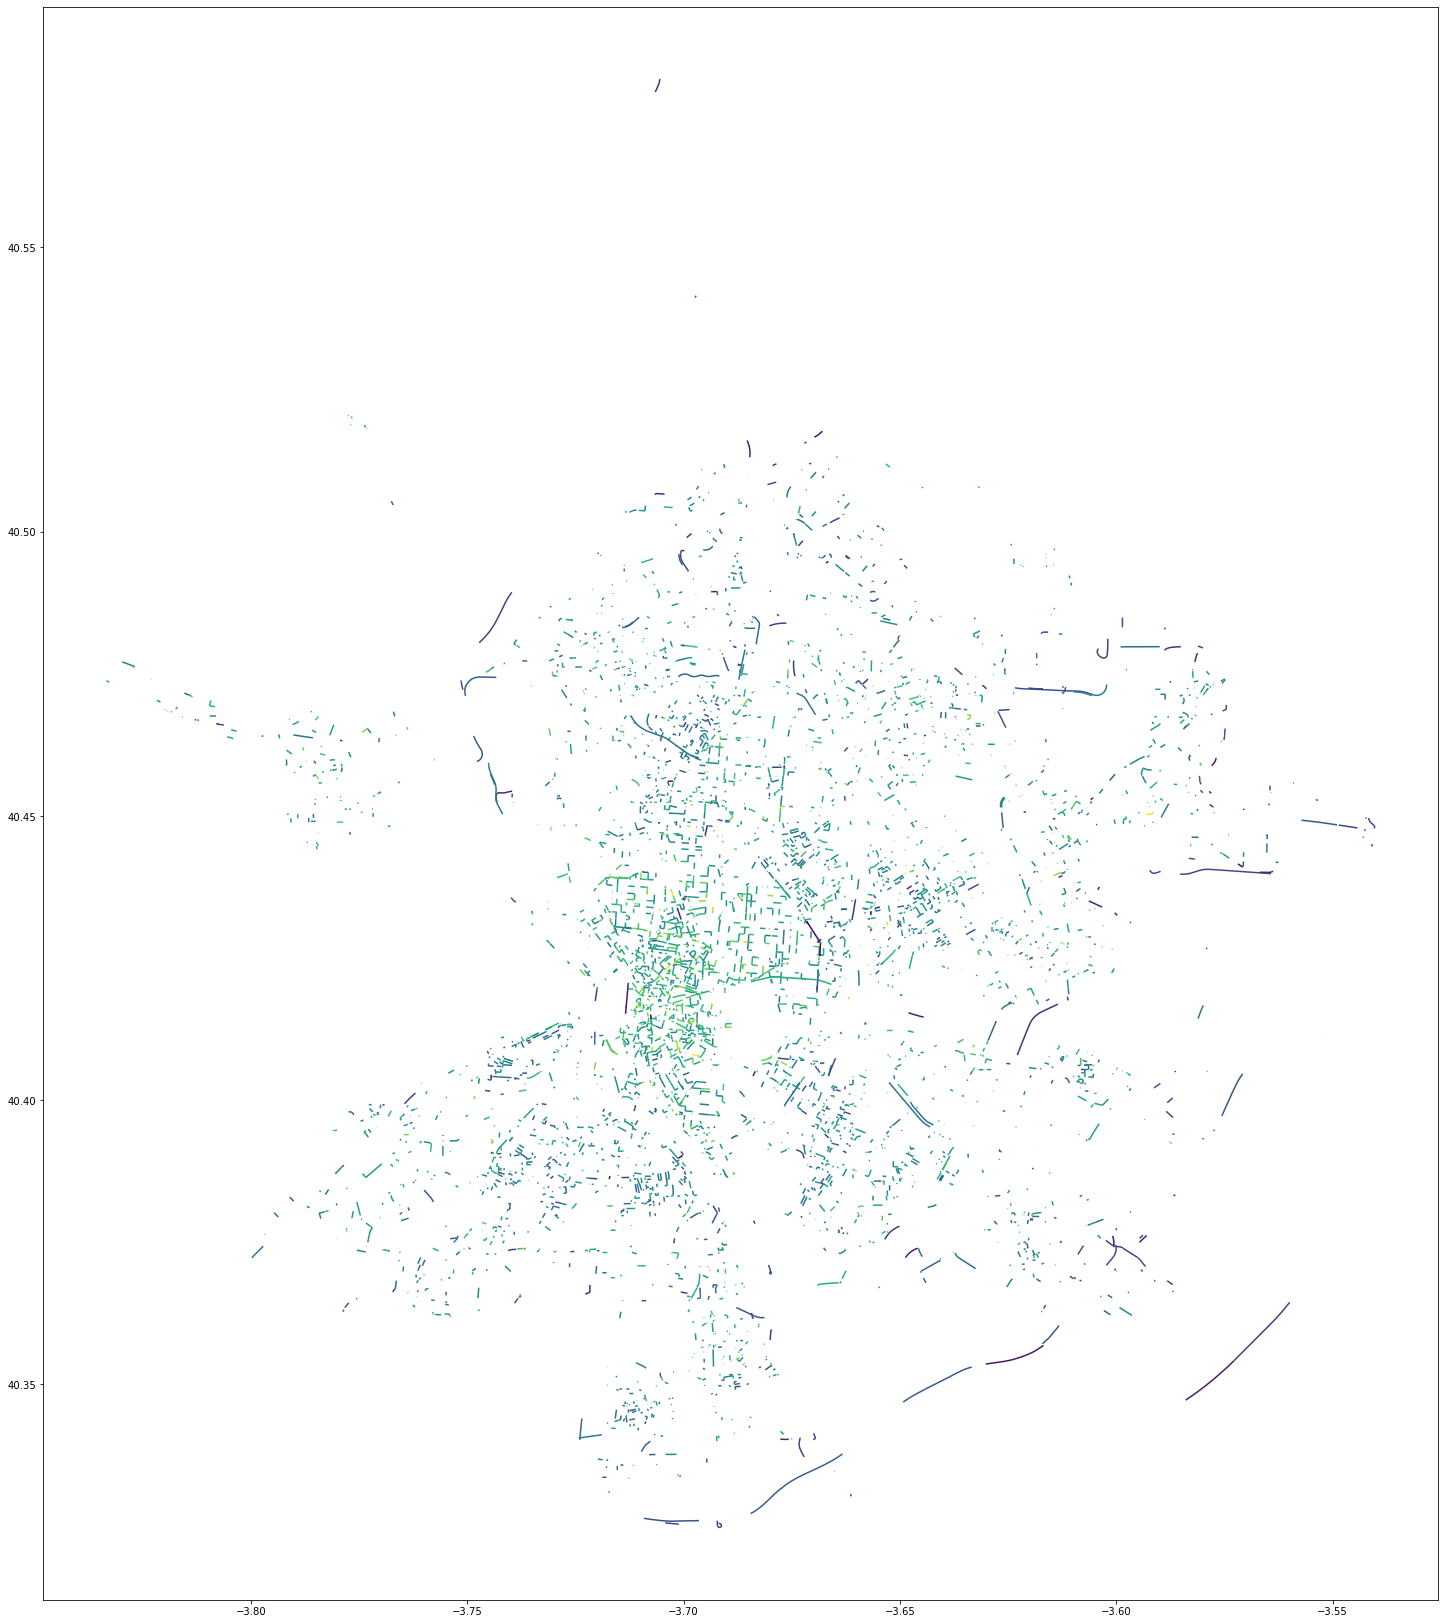

In [10]:
col_to_draw = 'value'
urban_df[['geometry', col_to_draw]].plot(figsize = (25,35), column = col_to_draw)
plt.show()

Los puntos pertenecientes a la valoración son algo escasos

In [13]:
urban_df.isna().sum()

OGC_FID                              0
geom_pu                              0
dist_barri                          16
dm_id                                0
train                                0
land_use_mix                         0
closeness_small_parks                0
residence_ratio                      0
block_area                           0
intersection_density                 0
anisotropicity                       0
average_age                          0
age_diversity                        0
age_deviation_diversity              0
built_density                        0
population_density                   0
ocasional_density                    0
proximity_density                    0
leisure_density                      0
educational_density                  0
nightlife_density                    0
culture_density                      0
closeness_large_parks                0
closeness_primary_roads              0
closeness_secondary_roads            0
closeness_tertiary_roads 

In [15]:
urban_df.shape

(66499, 61)

In [ ]:
## open shapefile in 